In [3]:
"""PyTorch CIFAR-10 image classification.

The code is generally adapted from 'PyTorch: A 60 Minute Blitz'. Further
explanations are given in the official PyTorch tutorial:

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
"""

# mypy: ignore-errors
# pylint: disable=W0223


from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

from spikingjelly.activation_based import surrogate, neuron, functional
from spikingjelly.activation_based.model import spiking_vgg
from spikingjelly.activation_based.model.tv_ref_classify import transforms, utils
from torch.utils.data.dataloader import default_collate
import torchvision
import random
import pickle
import time
import numpy as np

DTYPE = torch.float

BATCH_SIZE = 64
# DUMP_FILE_NAME = '/tmp/data/fed-data.pkl'
DUMP_FILE_NAME = '/tmp/data/fed-data-IID.pkl'

NUM_OUTPUTS = 10

# Temporal Dynamics
NUM_STEPS = 10

mixup_transforms = []
mixup_alpha=0.2
cutmix_alpha=1.0
if mixup_alpha > 0.0:
    if torch.__version__ >= torch.torch_version.TorchVersion('1.10.0'):
        pass
    else:
        # TODO implement a CrossEntropyLoss to support for probabilities for each class.
        raise NotImplementedError("CrossEntropyLoss in pytorch < 1.11.0 does not support for probabilities for each class."
                                    "Set mixup_alpha=0. to avoid such a problem or update your pytorch.")
    mixup_transforms.append(transforms.RandomMixup(10, p=1.0, alpha=mixup_alpha))
if cutmix_alpha > 0.0:
    mixup_transforms.append(transforms.RandomCutmix(10, p=1.0, alpha=cutmix_alpha))
if mixup_transforms:
    mixupcutmix = torchvision.transforms.RandomChoice(mixup_transforms)
    collate_fn = lambda batch: mixupcutmix(*default_collate(batch))  # noqa: E731

loader_g = torch.Generator()
loader_g.manual_seed(2023)

# Define Network
def load_model(num_classes=NUM_OUTPUTS):
    net = spiking_vgg.__dict__['spiking_vgg11_bn'](pretrained=False, spiking_neuron=neuron.LIFNode,
                                                    surrogate_function=surrogate.ATan(), 
                                                    detach_reset=True, num_classes=num_classes)
    functional.set_step_mode(net, step_mode='m')
    return net

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def load_train_data(dataset):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.RandomSampler(dataset, generator=loader_g),
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn,
        worker_init_fn=seed_worker,
        drop_last=True
    )

def load_val_data(dataset):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SequentialSampler(dataset),
        num_workers=0,
        pin_memory=True,
        worker_init_fn=seed_worker,
        drop_last=True
    )

def load_client_data(node_id: int):
    """Load partition CIFAR10 data."""
    with open(DUMP_FILE_NAME, 'rb') as file:
        # Load the data from the file
        trainsets, valsets, _ = pickle.load(file)

    return load_train_data(trainsets[node_id]), load_val_data(valsets[node_id])

def load_test_data():
    """Load test CIFAR10 data."""
    with open(DUMP_FILE_NAME, 'rb') as file:
        # Load the data from the file
        _, _, testset = pickle.load(file)

    return load_val_data(testset)

def preprocess_train_sample(x: torch.Tensor):
    # Define how to process training samples before sending them to the model
    return x.unsqueeze(0).repeat(NUM_STEPS, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]

def preprocess_test_sample(x: torch.Tensor):
    # Define how to process test samples before sending them to the model
    return x.unsqueeze(0).repeat(NUM_STEPS, 1, 1, 1, 1)  # [N, C, H, W] -> [T, N, C, H, W]

def process_model_output(y: torch.Tensor):
    # Define how to handle y = model(x)
    return y.mean(0)

def cal_acc1_acc5(output, target):
    # Define how to calculate acc1 and acc5
    acc1, acc5 = utils.accuracy(output, target, topk=(1, 5))
    return acc1, acc5


def train(model, optimizer, trainloader, device, epoch, model_ema=None, scaler=None):
    model_ema_steps = 32
    lr_warmup_epochs = 0

    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")

    header = f"Epoch: [{epoch}]"

    for image, target in metric_logger.log_every(trainloader, -1, header):
        start_time = time.time()
        image, target = image.to(device), target.to(device)

        with torch.cuda.amp.autocast(enabled=scaler is not None):
            image = preprocess_train_sample(image)
            output = process_model_output(model(image))      # Pulse firing frequency
            targets = torch.argmax(target, dim=1)
            label_one_hot = F.one_hot(targets, 10).float()
            loss = F.mse_loss(output, label_one_hot)  # The spike firing frequency of output layer neurons and the MSE of the real category

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        else:                   # If specified at runtime--disable-amp
            loss.backward()
            optimizer.step()
        functional.reset_net(model)
        

        if model_ema and i % model_ema_steps == 0:
            model_ema.update_parameters(model)
            if epoch < lr_warmup_epochs:
                # Reset ema buffer to maintain copy weights during warm-up
                model_ema.n_averaged.fill_(0)

        acc1, acc5 = cal_acc1_acc5(output, target)
        batch_size = target.shape[0]

        metric_logger.update(loss=loss.item(), lr=optimizer.param_groups[0]["lr"])
        metric_logger.meters["acc1"].update(acc1.item(), n=batch_size)
        metric_logger.meters["acc5"].update(acc5.item(), n=batch_size)
        metric_logger.meters["img/s"].update(batch_size / (time.time() - start_time))

        del image, target

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    train_loss, train_acc1, train_acc5 = metric_logger.loss.global_avg, metric_logger.acc1.global_avg, metric_logger.acc5.global_avg
    # print(f'Train: train_acc1={train_acc1:.3f}, train_acc5={train_acc5:.3f}, train_loss={train_loss:.6f}, samples/s={metric_logger.meters["img/s"]}')

    return train_loss, train_acc1


def test(model, data_loader, device, log_suffix=""):
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = f"Test: {log_suffix}"

    num_processed_samples = 0
    start_time = time.time()
    with torch.inference_mode():
        for image, target in metric_logger.log_every(data_loader, -1, header):
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            image = preprocess_test_sample(image)
            output = process_model_output(model(image))
            label_one_hot = F.one_hot(target, 10).float()
            loss = F.mse_loss(output, label_one_hot)  # The spike firing frequency of output layer neurons and the MSE of the real category

            acc1, acc5 = cal_acc1_acc5(output, target)
            # FIXME need to take into account that the datasets
            # could have been padded in distributed setup
            batch_size = target.shape[0]
            metric_logger.update(loss=loss.item())
            metric_logger.meters["acc1"].update(acc1.item(), n=batch_size)
            metric_logger.meters["acc5"].update(acc5.item(), n=batch_size)
            num_processed_samples += batch_size
            functional.reset_net(model)

    # Collect statistics for all processes
    num_processed_samples = utils.reduce_across_processes(num_processed_samples)

    metric_logger.synchronize_between_processes()

    test_loss, test_acc1, test_acc5 = metric_logger.loss.global_avg, metric_logger.acc1.global_avg, metric_logger.acc5.global_avg
    print(f'Test: test_acc1={test_acc1:.3f}, test_acc5={test_acc5:.3f}, test_loss={test_loss:.6f}, samples/s={num_processed_samples / (time.time() - start_time):.3f}')
    return test_loss, test_acc1

In [4]:
def train_wo_noise():
    DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    
    print("Centralized PyTorch training")
    print("Load data")
    trainloader, testloader = load_client_data(0)
    net = load_model().to(DEVICE)
    net.eval()
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.0)

    hist = []
    for epoch in range(20):
        print(epoch)
        train(model=net, optimizer=optimizer, trainloader=trainloader, device=DEVICE, epoch=1)
        loss, accuracy = test(model=net, data_loader=testloader, device=DEVICE)
        print(f"Loss: {loss}, Accuracy: {accuracy}")
        hist.append((loss, accuracy))
    return hist


wo_noise_hist = train_wo_noise()


Centralized PyTorch training
Load data
0
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:02
Test: test_acc1=14.309, test_acc5=55.428, test_loss=0.088962, samples/s=443.257
Loss: 0.08896192124015406, Accuracy: 14.30921052631579
1
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=21.957, test_acc5=73.684, test_loss=0.085481, samples/s=1161.520
Loss: 0.08548135506479364, Accuracy: 21.957236842105264
2
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=25.329, test_acc5=77.714, test_loss=0.082810, samples/s=1163.781
Loss: 0.08280965528990093, Accuracy: 25.32894736842105
3
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=27.138, test_acc5=83.635, test_loss=0.079920, samples/s=1175.693
Loss: 0.07992040483575118, Accuracy: 27.138157894736842
4
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=30.181, test_acc5=84.622, test_loss=0.076861, samples/s=1171.534
Loss: 0.07686101762871993, Accuracy

In [5]:
def add_noise_to_model(model, device, mean=0, std=0.01):
    with torch.no_grad():
        for param in model.parameters():
            param.add_(torch.randn(param.size()).to(device) * std + mean)


def train_w_noise(mean, std):
    DEVICE = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    
    print("Centralized PyTorch training")
    print("Load data")
    trainloader, testloader = load_client_data(0)
    net = load_model().to(DEVICE)
    net.eval()
    optimizer = torch.optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.0)

    training_record = []
    for epoch in range(20):
        print(epoch)
        add_noise_to_model(net, DEVICE, mean, std)
        train(model=net, optimizer=optimizer, trainloader=trainloader, device=DEVICE, epoch=1)
        loss, accuracy = test(model=net, data_loader=testloader, device=DEVICE)
        print(f"Loss: {loss}, Accuracy: {accuracy}")
        training_record.append((loss, accuracy))
    return training_record


w_noise_hist = train_w_noise(0, 0.01)
w_noise_hist_2 = train_w_noise(0, 0.015)
w_noise_hist_3 = train_w_noise(0, 0.02)

Centralized PyTorch training
Load data
0
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=16.776, test_acc5=72.368, test_loss=0.086936, samples/s=1185.534
Loss: 0.08693643620139674, Accuracy: 16.776315789473685
1
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=21.217, test_acc5=77.632, test_loss=0.084964, samples/s=1177.381
Loss: 0.08496419379585668, Accuracy: 21.217105263157894
2
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=20.724, test_acc5=80.016, test_loss=0.085162, samples/s=1179.842
Loss: 0.08516202474895276, Accuracy: 20.723684210526315
3
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=29.523, test_acc5=81.497, test_loss=0.082538, samples/s=1187.215
Loss: 0.08253780164216694, Accuracy: 29.523026315789473
4
Epoch: [1] Total time: 0:00:12
Test:  Total time: 0:00:01
Test: test_acc1=33.635, test_acc5=84.211, test_loss=0.078860, samples/s=1168.000
Loss: 0.07885995036677311, Accur

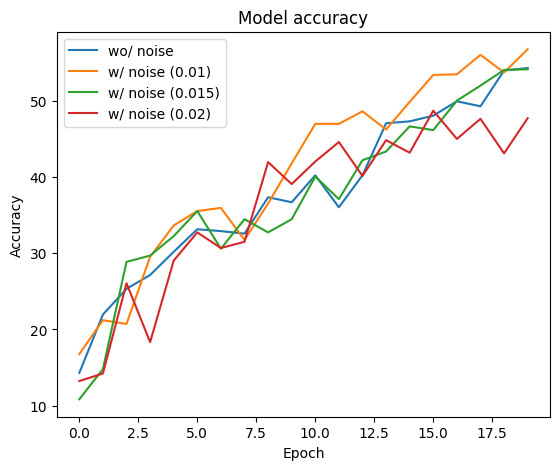

In [6]:
import matplotlib.pyplot as plt

# Assuming history is your model's history object containing 'loss', 'accuracy', 'val_loss', and 'val_accuracy' metrics

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot([item[1] for item in wo_noise_hist], label='wo/ noise')
plt.plot([item[1] for item in w_noise_hist], label='w/ noise (0.01)')
plt.plot([item[1] for item in w_noise_hist_2], label='w/ noise (0.015)')
plt.plot([item[1] for item in w_noise_hist_3], label='w/ noise (0.02)')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history['loss'], label='Train')
# if 'val_loss' in history:
#     plt.plot(history['val_loss'], label='Validation')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

plt.show()
